**After this laboratory you should be able to**
- Explain what is a **community**. Explain the structural and interpersonal perspective
- Explain **modularity**.
- Explain how to find communities based on hierarchical models. Understand the **Graph partitioning** and **Louvain algorithm**
- Explore k-clique percolation

In [1]:
import itertools
import os
import random
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
import scipy.stats as st
from scipy.io import mmread
from tqdm.notebook import tqdm

## Utils

In [2]:
parent_dir = os.path.abspath(os.path.join(".."))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)

from utils.utils import (
    average_clustering,
    average_degree,
    connectivity_perc,
    giant_component,
    load_graph,
    print_stats,
)

In [3]:
# Helper functions
def communities_to_dict(communities):
    """Transforms a communities list formed from a list of sets [{u1, u2, ...}, {v1, v2, ...}, ...] into a {node:community} dict"""
    d = {}
    for v in range(len(communities)):
        for k in communities[v]:
            d[k] = v
    return d


def dict_to_communities(d):
    """Transforms a dict from {node: community} to a communities where each set is a community of nodes [{}, {}]"""
    return [
        {u for u, si in d.items() if si == s}
        for s in np.unique(list(d.values()))
    ]

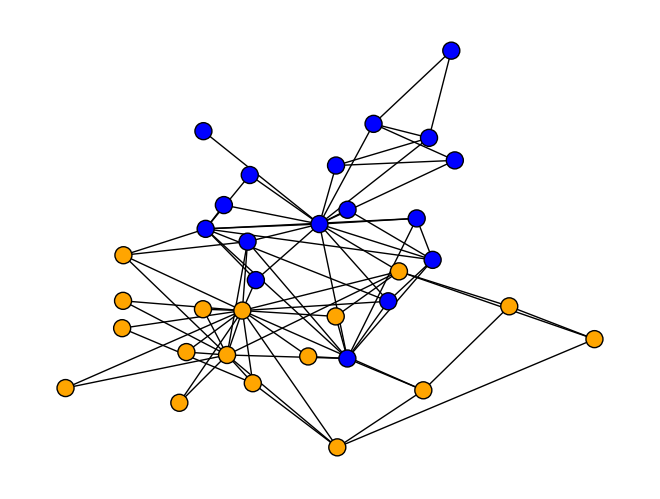

In [4]:
G_karate = nx.karate_club_graph()
node_color = [
    "blue" if club == "Mr. Hi" else "orange"
    for club in list(nx.get_node_attributes(G_karate, "club").values())
]
nx.draw_kamada_kawai(
    G_karate, node_color=node_color, node_size=150, edgecolors="black"
)

In [5]:
G_football = load_graph("football")

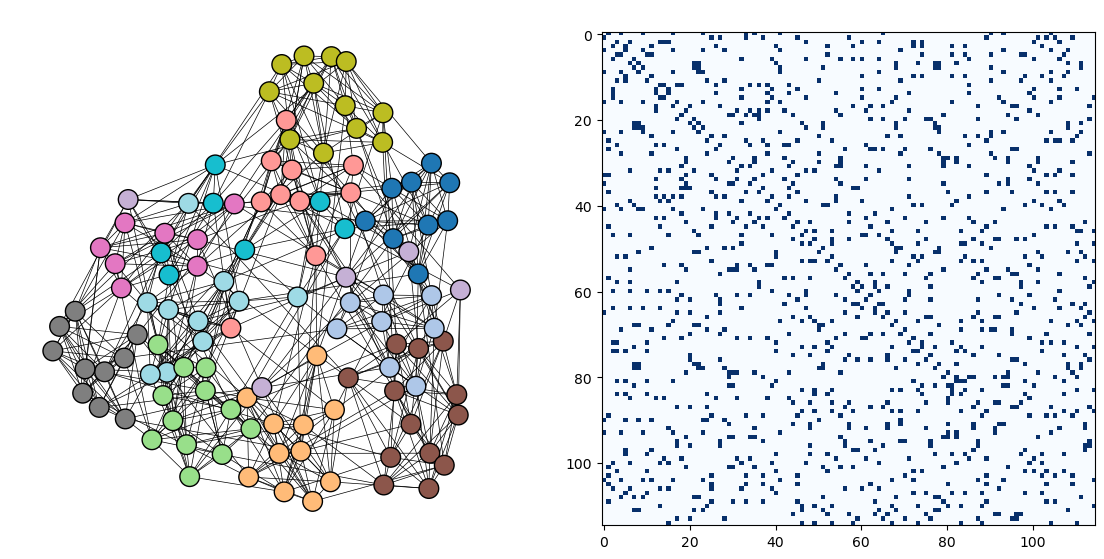

In [7]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G_football, k=2, iterations=1000, seed=42)
nx.draw(
    G_football,
    pos=pos,
    node_size=200,
    width=0.5,
    edgecolors="black",
    node_color=list(nx.get_node_attributes(G_football, "value").values()),
    cmap=plt.cm.tab20,
)

A = nx.adjacency_matrix(G_football).todense()
plt.subplot(1, 2, 2)
plt.imshow(A, cmap="Blues")

plt.show()

In [8]:
communities = dict_to_communities(nx.get_node_attributes(G_football, "value"))

In [9]:
communities

[{1, 25, 33, 37, 45, 89, 103, 105, 109},
 {19, 29, 30, 35, 55, 79, 94, 101},
 {2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106},
 {3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107},
 {44, 48, 57, 66, 75, 86, 91, 92, 110, 112},
 {36, 42, 80, 82, 90},
 {12, 14, 18, 26, 31, 34, 38, 43, 54, 61, 71, 85, 99},
 {0, 4, 9, 16, 23, 41, 93, 104},
 {7, 8, 21, 22, 51, 68, 77, 78, 108, 111},
 {17, 20, 27, 56, 62, 65, 70, 76, 87, 95, 96, 113},
 {11, 24, 50, 59, 63, 69, 97},
 {28, 46, 49, 53, 58, 67, 73, 83, 88, 114}]

In [10]:
communities_to_dict(communities) == nx.get_node_attributes(G_football, "value")

True

# Communities

**Problem: Community detection**  
We are trying to cluster nodes together such that they form a community.

**What is a community?**  
Locally dense connected subgraphs in a network.
1. *Connectedness hypothesis*: Each community corresponds to a connected subgraph
2. *Density Hypothesis*: Nodes in a community are more likely to connect to other members of the same community than to nodes in other communities.

*Intuition:*  
In other words, all members of a community must be reached through other members of the same community (connectedness). At the same time we expect that nodes that belong to a community have a higher probability to link to the other members of that community than to nodes that do not belong to the same community (density).

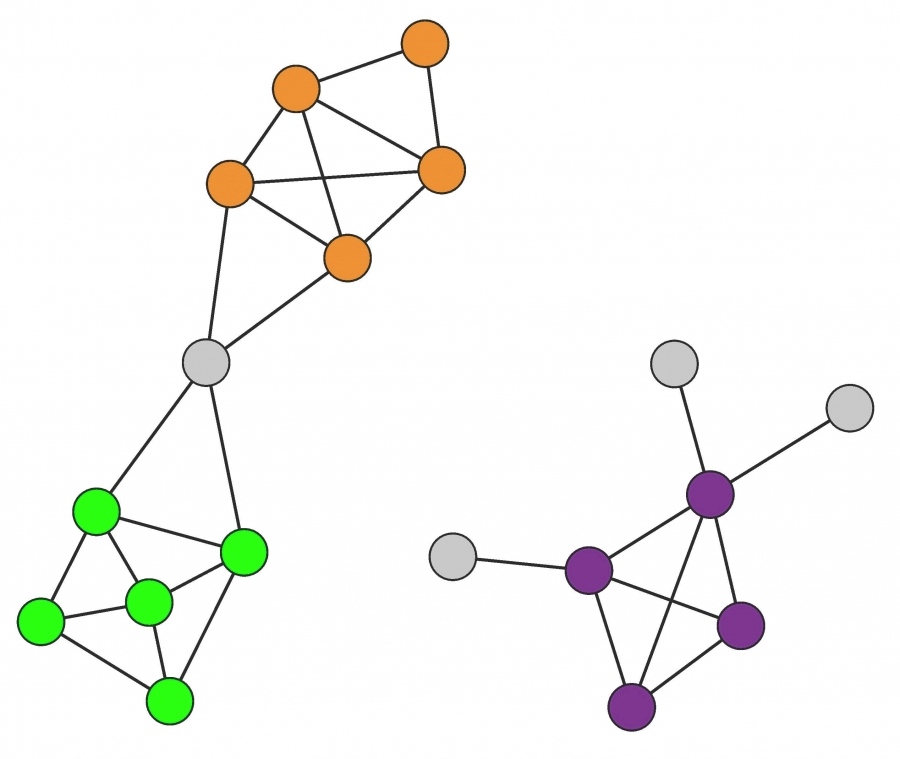

**Community -- Definitions**  
Sets of tightly connected nodes:
- **Cliques**  
    A clique corresponds to a complete subgraph. The highest order clique of this network is a square, shown in orange. There are several three-node cliques on this network.  
    https://en.wikipedia.org/wiki/Clique_problem
- **Strong Communities**  
    A strong community is a connected subgraph whose nodes have more links to other nodes in the same community that to nodes that belong to other communities. Such a strong community is shown in purple. There are additional strong communities on the graph.
- **Weak Communities**  
    A weak community is a subgraph whose nodes' total internal degree exceeds their total external degree. The green nodes represent one of the several possible weak communities of this network.

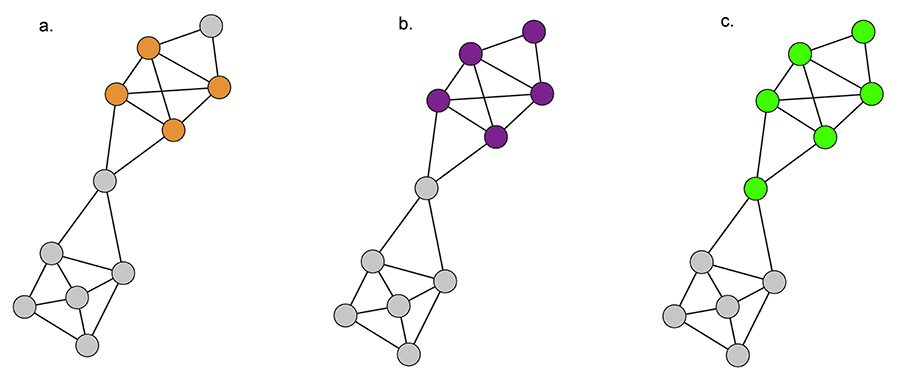




In [11]:
import matplotlib

In [12]:
matplotlib.colors.BASE_COLORS

{'b': (0, 0, 1),
 'g': (0, 0.5, 0),
 'r': (1, 0, 0),
 'c': (0, 0.75, 0.75),
 'm': (0.75, 0, 0.75),
 'y': (0.75, 0.75, 0),
 'k': (0, 0, 0),
 'w': (1, 1, 1)}

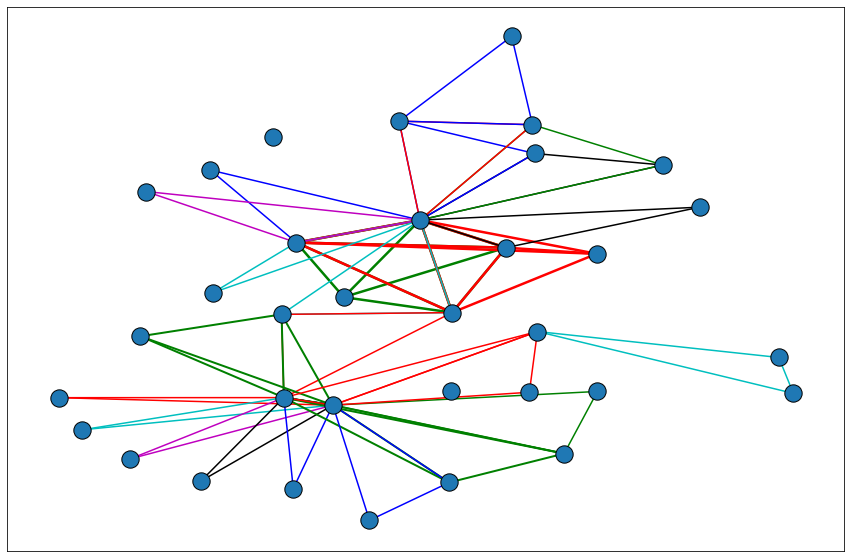

In [24]:
# Let's look at cliques in a graph
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G_karate)
nx.draw_networkx_nodes(G_karate, pos=pos, edgecolors="black")

colors = ["b", "g", "r", "c", "m", "k"]

for i, clique in enumerate(nx.find_cliques(G_karate)):
    if len(clique) >= 3:
        edges = list(itertools.combinations(clique, 2))  # pair of edges
        edge_color = [colors[i % len(colors)]] * len(edges)
        nx.draw_networkx_edges(
            G_karate,
            pos=pos,
            edgelist=edges,
            edge_color=edge_color,
            width=len(clique) / 2,
        )

# Social network analysis

**Social networks**  
Graph $G = (V, E, W)$
- Nodes $N$ = individuals
- Edges $E$ = interactions, relationships
- Edge weight $W$= Strength of the relationship

We have 2 perspectives on edges
1. **Structural** - is the edge in a community or is the edge connecting different communities? (bridge-like)
2. **Interpesonal** -- Friendships are either *strong* or *weak* (edge weight)

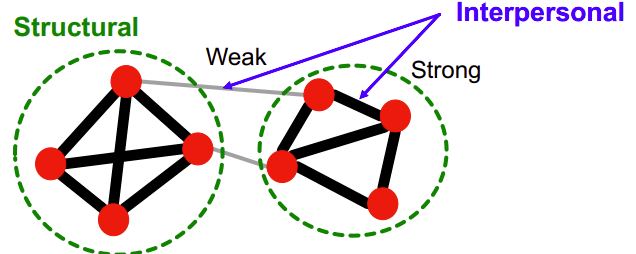

The 2 perspectives are related
1. Structurally embedded edges are socially *strong*, long edges connecting different parts f the network are *weak*
2. *Long* edes allow you to gather information from different communities. *Strong* edges are redundant



**Remark**
- Social networks evovle such that communities evolve. If I, A, am friend with B and C there is a likely probability that B and C are / will be friends too

So an idea would be to cluster together nodes that have strong connections

# Metrics


## Community densities

*Intuition*: Number of edges / number of total possible edges

Graph $G = (V, E), n = |V|, m = |E|$

**Graph density**

$$\rho = \dfrac m {n(n-1) / 2}$$

**Community internal density**
$$\rho = \dfrac {m_s} {n_s(n_s-1) / 2}$$
**Community external density**
$$\rho = \dfrac {m_{ext}} {n_s(n_s-1) / 2}$$

Community if $\delta_{in} > \rho > \delta_{ext}$

- $-$ Very expensive to go through all groups and determine communities

## Modularity

**Modularity**  
How well a network is partitioned into communities:

$$Q \propto \sum_{s \in S}   (\text{# edges within group $s$}) - \underbrace{(\text{# expected edges within group $s$})}_{\text{random graph like ER}}$$

If we are to rewire the whole network the chance of 2 nodes to be connected is $\dfrac {k_ik_j} {2m}$

$$Q(G, S) = \underbrace{\dfrac 1 {2m}}_{\text{normalizing const}} \sum_{s \in S} \underbrace{\sum_{i \in s}\sum_{j \in s}\left(A_{ij} - \dfrac {k_ik_j} {2m} \right)}_{\text{ for each group $s$}} = \sum_{s \in S} \left( \dfrac {m_s} m - \left(\dfrac {k_s} {2m} \right) ^2\right)$$

Where  
$m_s$ = number of internal edges in a community $s$  
$k_s$ = sum  of node degrees within a community $s$




**Remarks**
- $Q \in [-1, 1]$, usually if $Q \in [0.3, 0.7]$ that means significant community structure
- $Q = 0$ is we have 1 community
- When we try to find communities we can use this as an objective function that we try to maximize when we search for communities

In [13]:
from typing import List, Set

from networkx.algorithms.community.quality import (
    is_partition,
    modularity,
    partition_quality,
)

In [16]:
def my_modularity(G: nx.Graph, communities: List[Set]) -> float:
    """
    Calculate modularity given a graph G and a list of communities
    """
    assert is_partition(
        G, communities
    ), "communities must be a partition of G's nodes"
    m = G.number_of_edges()
    Q = 0
    for community in communities:
        s = nx.subgraph(G, community)  # group s
        ms = s.number_of_edges()
        ks = sum(G.degree(u) for u in s.nodes)
        Q += ms / m - (ks / (2 * m)) ** 2
    return Q

[{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


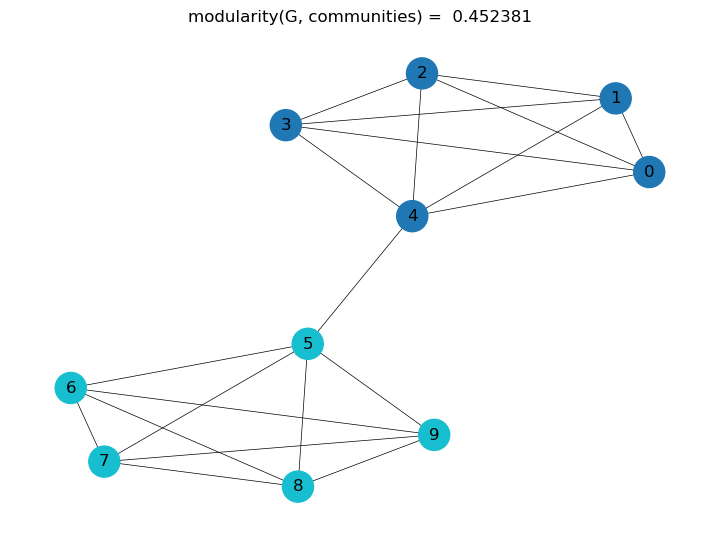

In [19]:
# Check a barbell graph
n_ = 5
n = 2 * n_
G = nx.barbell_graph(n_, 0)
communities = [set(range(n_)), set(range(n_, n))]  # Communities
print(communities)

node_color = list(communities_to_dict(communities).values())
print(node_color)
plt.figure(figsize=(7, 5))
nx.draw_kamada_kawai(
    G,
    with_labels=True,
    width=0.5,
    node_color=node_color,
    node_size=500,
    cmap=plt.cm.tab10,
)

plt.title(f"{modularity(G, communities) = : 2f}")
plt.show()

In [20]:
my_modularity(G, communities) == modularity(G, communities)

True

# Finding communities

To find communities we usually used hierarchical clustering methods. We usually try to partition the graph by **eliminating edges** or we try to **combine nodes** into super-nodes and build up communities

## Graph partitioning

Splits into communities. Top-down approach

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the *most valuable edge*, traditionally the edge with the highest betweenness centrality, at each step.  
As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

**Remark**
- The edge value function can be whatever we want.


In [22]:
from networkx.algorithms.community import girvan_newman

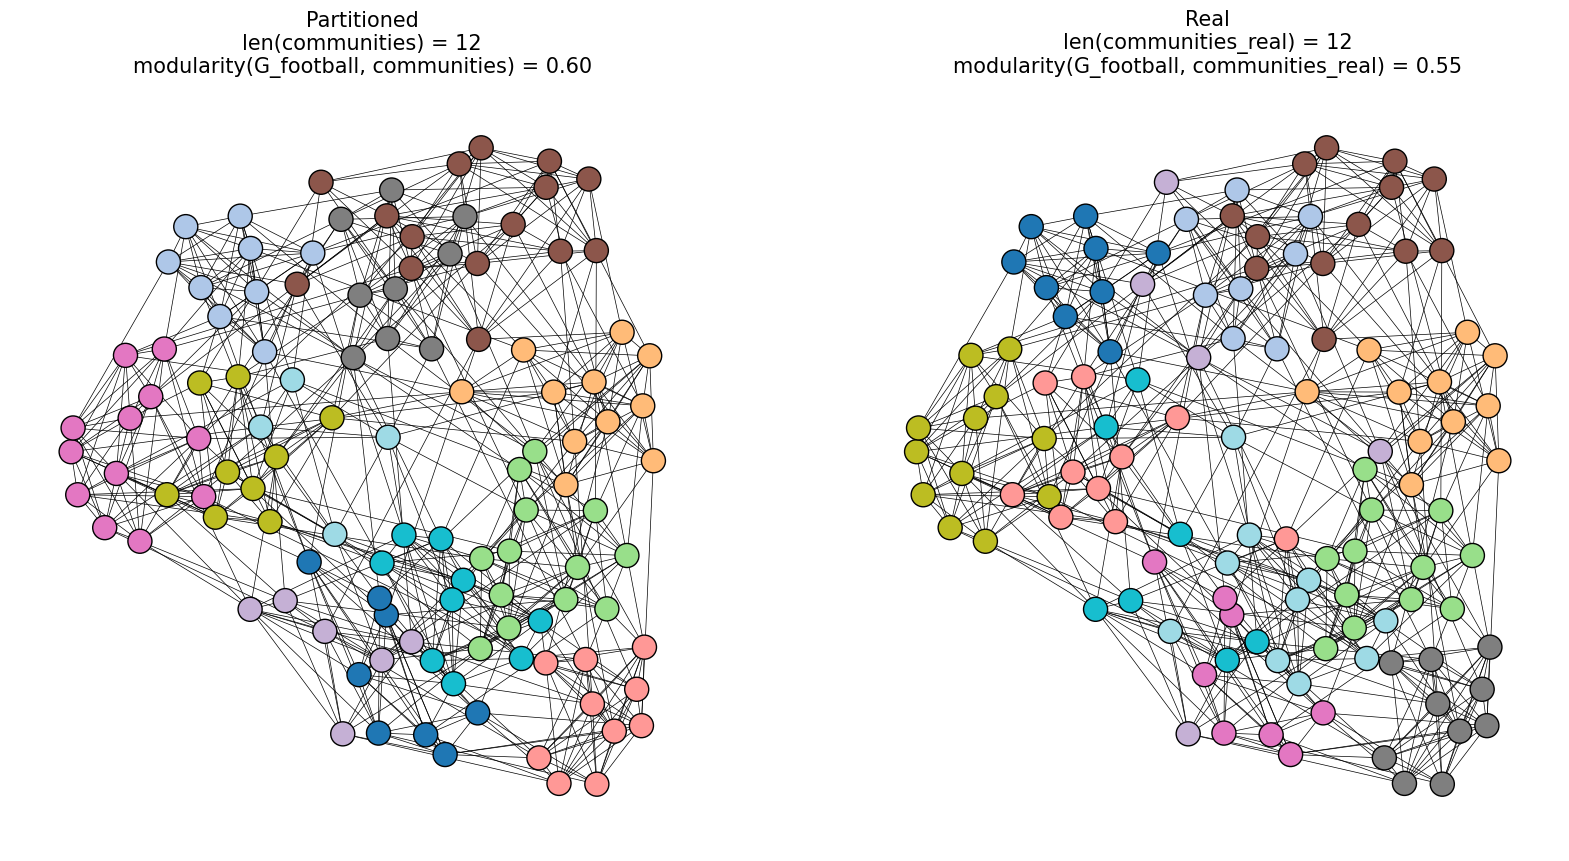

In [23]:
pos = nx.spring_layout(G_football, k=2, iterations=1000)

# Partitioned

## This is from the `girvan_newman` docs
k = 12  # take at most k elements for each community
comp = girvan_newman(G_football)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    communities = list(sorted(c) for c in communities)

d = communities_to_dict(communities)


node_color = list(d.values())  # Community color
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
nx.draw(
    G_football,
    nodelist=d.keys(),
    pos=pos,
    edgecolors="black",
    width=0.5,
    node_color=node_color,
    cmap=plt.cm.tab20,
    ax=axs[0],
)
axs[0].set_title(
    f"Partitioned\n{len(communities) = }\n{modularity(G_football, communities) = :.2f}",
    size=15,
)

# Real
d = nx.get_node_attributes(G_football, "value")
communities_real = dict_to_communities(d)
node_color = list(d.values())  # Community color
nx.draw(
    G_football,
    pos=pos,
    edgecolors="black",
    width=0.5,
    node_color=node_color,
    cmap=plt.cm.tab20,
    ax=axs[1],
)

axs[1].set_title(
    f"Real\n{len(communities_real) = }\n{modularity(G_football, communities_real) = :.2f}",
    size=15,
)
plt.show()

**Remark**
- If we keep splitting we are not getting better modularity

In [34]:
modularities = []
communities_lengths = []
for communities in girvan_newman(G_football):
    modularities.append(modularity(G_football, communities))
    communities_lengths.append(len(communities))

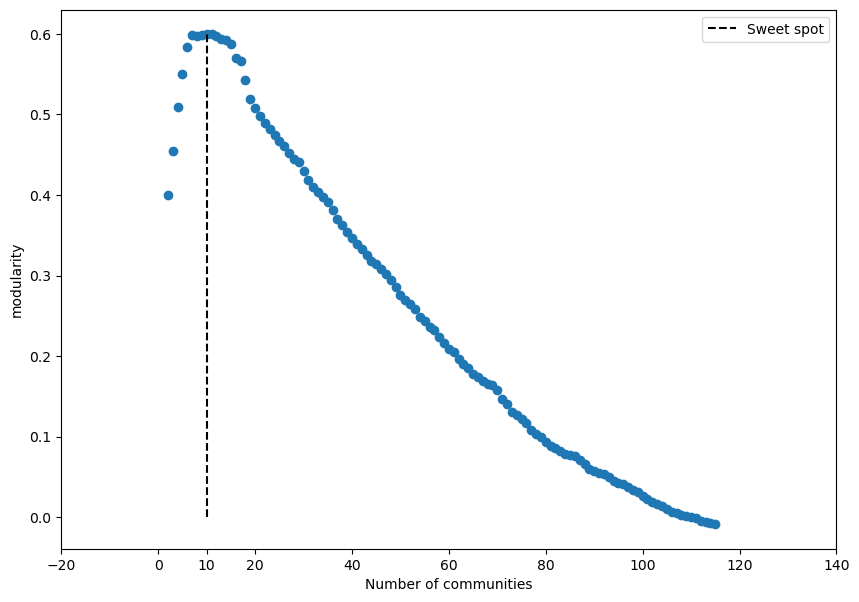

In [35]:
best_modularity = np.max(modularities)
best_comm_len = communities_lengths[np.argmax(modularities)]

plt.figure(figsize=(10, 7))
plt.scatter(communities_lengths, modularities)
plt.xlabel("Number of communities")
plt.ylabel("modularity")

np.argmax(modularities)
plt.plot([best_comm_len] * 2, [0, best_modularity], "k--", label="Sweet spot")
plt.xticks(list(plt.xticks()[0]) + [best_comm_len])
plt.legend()
# plt.title("There is a sweet spot")
plt.show()

## Louvain algorithm

[nx louvain docs](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)

Builds communities.  Bottom-up approach  
Greedy algorithm for community detection -- $\mathcal O(n \log n)$ runtime  
- Supports weighted graphs  
- Provides hierarchical communities
- $+$ fast
- $+$ finds communities with high modularities

*Intuition*: We try to greedily take steps that maximize modularity.

2 phases that repeat until we can't increase modularity
1. Optimize modularity by allowing only local changes to node-communities memberships. For every node $i$ I try to put it in a community with a neighbour $j$. The goal is form a community that yields the largest gain $\Delta Q$. This steps stops when there is no gain in modularity
2. Aggregate the communities formed into super-nodes. goto phase 1

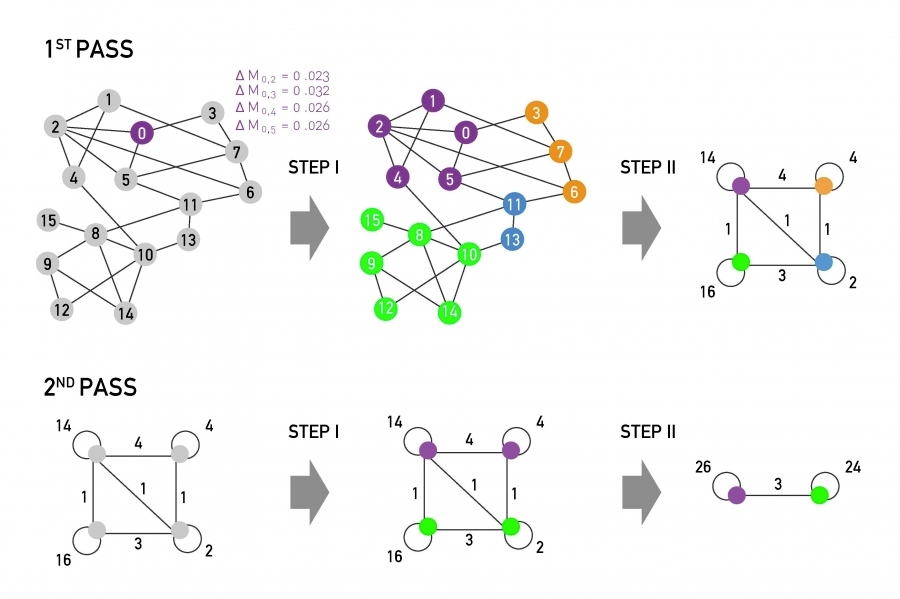


In [32]:
# https://github.com/taynaud/python-louvain
#!pip install python-louvain

In [37]:
from networkx.algorithms.community import louvain_communities, louvain_partitions

In [38]:
louvain_communities(G_football)

[{2, 6, 13, 15, 32, 39, 47, 60, 64, 100, 106},
 {19, 29, 30, 35, 55, 79, 80, 82, 94, 101},
 {1, 25, 33, 37, 45, 89, 103, 105, 109},
 {12, 14, 18, 26, 31, 34, 36, 38, 42, 43, 54, 61, 71, 85, 99},
 {46, 49, 53, 67, 73, 83, 88, 110, 114},
 {3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107},
 {44, 48, 57, 66, 75, 86, 91, 92, 112},
 {0, 4, 9, 11, 16, 23, 24, 28, 41, 50, 69, 90, 93, 104},
 {7, 8, 21, 22, 51, 68, 77, 78, 108, 111},
 {17, 20, 27, 56, 58, 59, 62, 63, 65, 70, 76, 87, 95, 96, 97, 113}]

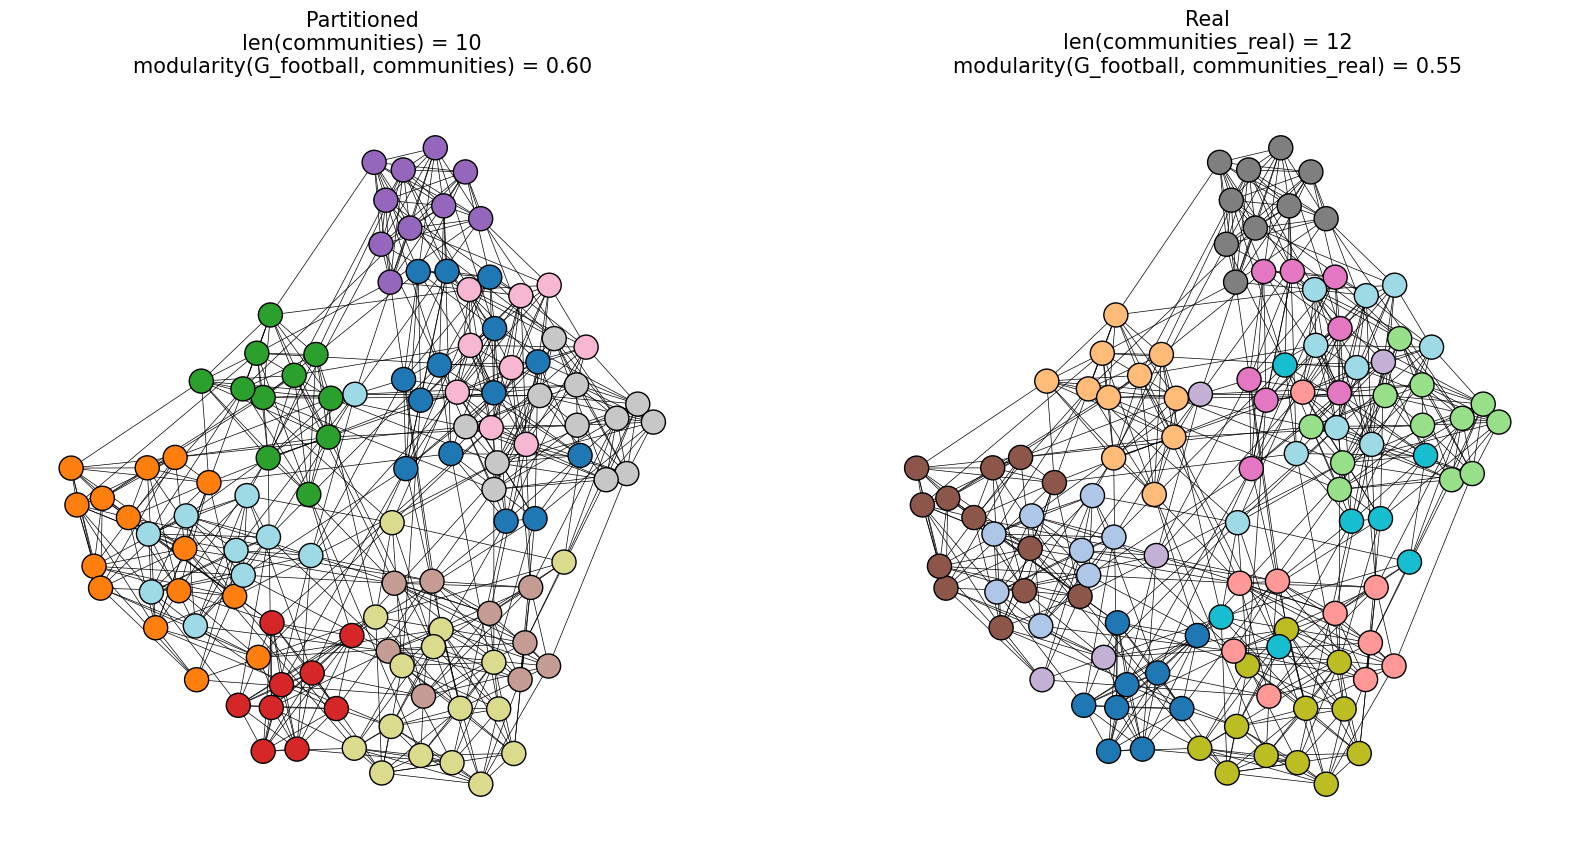

In [51]:
pos = nx.spring_layout(G_football, k=2, iterations=1000)


# Partitioned
communities = louvain_communities(G_football)
d = communities_to_dict(communities)
node_color = list(d.values())  # Community color
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# Notice the nodelist because nodes got shuffled when we made them back to dict
nx.draw(
    G_football,
    nodelist=d.keys(),
    pos=pos,
    edgecolors="black",
    width=0.5,
    node_color=node_color,
    cmap=plt.cm.tab20,
    ax = axs[0],
)
axs[0].set_title(
    f"Partitioned\n{len(communities) = }\n{modularity(G_football, communities) = :.2f}",
    size=15,
)

# Real
d = nx.get_node_attributes(G_football, "value")
communities_real = dict_to_communities(d)
node_color = list(d.values())
nx.draw(
    G_football,
    pos=pos,
    edgecolors="black",
    width=0.5,
    node_color=node_color,
    cmap=plt.cm.tab20,
    ax = axs[1],
)

axs[1].set_title(
    f"Real\n{len(communities_real) = }\n{modularity(G_football, communities_real) = :.2f}",
    size=15,
)
plt.show()

## Other ways to find communities

### Walktrap
*Intuition*: random walks tend to get trapped into communities. Do random walks and see where the walk spends most of its time.



# Overlapping communities

Maybe there are nodes that are in multiple communities. Example: A person might be part of many communities. In this case the methods that cut edges or cluster nodes toghether don't work

## k-clique percolation (CFinder)

The clique percolation algorithm, views a community as the union of overlapping cliques:
- Two k-cliques are considered **adjacent** if they share $k – 1$ nodes (b.)
- A **k-clique community** is the largest connected subgraph obtained by the union of all adjacent k-cliques (c.).
- k-cliques that can not be reached from a particular k-clique belong to other k-clique communities (d.).

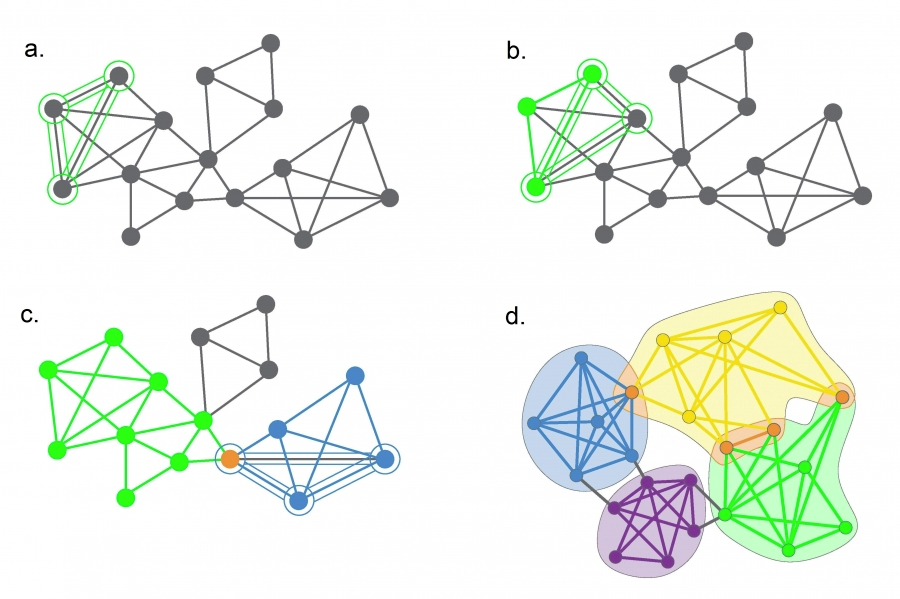



- $-$ Very expensive - grows exponentially with the number of nodes. If we are not using maximal cliques we can finish in polynomial time
- $-$ Networks must be dense


In [52]:
from networkx.algorithms.community import k_clique_communities

In [53]:
k = 3
communities = list(k_clique_communities(G_football, k))
print(len(communities))
print(communities[0].intersection(communities[1]))

4
frozenset({0, 80, 109, 62})
